# Bitcoin OTC and Alpha n and p into Random graph models
## To see if characteristics are actaully significant, just compared to a random graph

In [3]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

alpha_df = pd.read_csv('../../soc-sign-bitcoinalpha.csv', header=None)
alpha_df.columns = ['source', 'target', 'weight', 'timestamp']

OTC_df = pd.read_csv('../../soc-sign-bitcoinotc.csv', header=None)
OTC_df.columns = ['source', 'target', 'weight', 'timestamp']

# Alpha Graph Construction
alpha_G = nx.DiGraph()
for src, tgt, _, _ in zip(alpha_df['source'], alpha_df['target'], alpha_df['weight'], alpha_df['timestamp']):
    u = int(src)
    v = int(tgt)
    alpha_G.add_edge(u, v)  # no weight for laplcian computation

# OTC graph construction
otc_G = nx.DiGraph()
for src, tgt, _, _ in zip(OTC_df['source'], OTC_df['target'], OTC_df['weight'], OTC_df['timestamp']):
    u = int(src)
    v = int(tgt)
    otc_G.add_edge(u, v)  # no weight for laplcian computation

# Convert to undirected for Laplacian
alpha_undirected = alpha_G.to_undirected()
otc_undirected = otc_G.to_undirected()

# Plotting eigenvalue graph of random graph model

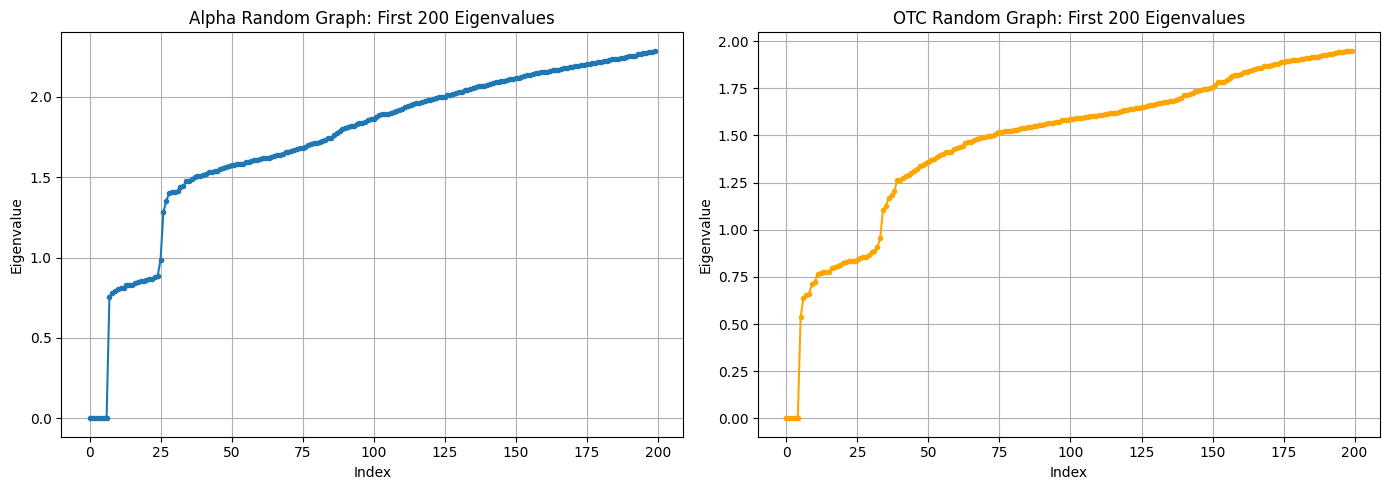

In [4]:
# Estimate n and p for Erdős–Rényi model
def estimate_n_p(G):
    n = G.number_of_nodes()
    m = G.number_of_edges()
    p = 2 * m / (n * (n - 1))  # p = 2m / (n(n-1)) for undirected graphs
    return n, p

n_alpha, p_alpha = estimate_n_p(alpha_undirected)
n_otc, p_otc = estimate_n_p(otc_undirected)

# Generate random graphs with matching n and p
alpha_random = nx.erdos_renyi_graph(n_alpha, p_alpha)
otc_random = nx.erdos_renyi_graph(n_otc, p_otc)

# Compute Laplacians
L0_alpha_rand = nx.laplacian_matrix(alpha_random).astype(float).toarray()
L0_otc_rand = nx.laplacian_matrix(otc_random).astype(float).toarray()

# Compute eigenvalues
eigen_alpha_rand = eigh(L0_alpha_rand, eigvals_only=True)
eigen_otc_rand = eigh(L0_otc_rand, eigvals_only=True)

# Plot first 200 eigenvalues
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(range(200), eigen_alpha_rand[:200], marker='o', markersize=3)
plt.title("Alpha Random Graph: First 200 Eigenvalues")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(200), eigen_otc_rand[:200], marker='o', markersize=3, color='orange')
plt.title("OTC Random Graph: First 200 Eigenvalues")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True)

plt.tight_layout()
plt.show()


In [5]:
# Print number of disconnected components
print("Number of disconnected components in Alpha Random Graph:", nx.number_connected_components(alpha_random))
print("Number of disconnected components in OTC Random Graph:", nx.number_connected_components(otc_random))

Number of disconnected components in Alpha Random Graph: 1
Number of disconnected components in OTC Random Graph: 6


In [6]:
# Calculate the disconnected components number of elements in each of the 4 disconnected components
alpha_components = [len(c) for c in nx.connected_components(alpha_random)]
otc_components = [len(c) for c in nx.connected_components(otc_random)]
print("Sizes of disconnected components in Alpha Random Graph:", alpha_components)
print("Sizes of disconnected components in OTC Random Graph:", otc_components)

Sizes of disconnected components in Alpha Random Graph: [3783]
Sizes of disconnected components in OTC Random Graph: [5876, 1, 1, 1, 1, 1]


### Statistical significance test on all clusters being size 2 vs. random graph

In [7]:
import networkx as nx
import numpy as np

def is_all_small_components(G):
    sizes = sorted([len(c) for c in nx.connected_components(G)], reverse=True)
    return all(size <= 2 for size in sizes[1:])  # exclude largest

count = 0
trials = 1000
for _ in range(trials):
    G = nx.gnp_random_graph(1000, 0.001)
    if not nx.is_connected(G) and is_all_small_components(G):
        count += 1

probability = count / trials
print(f"Estimated probability: {probability:.3f}")

Estimated probability: 0.000


## L1 Random Hodge Laplcian

In [11]:
from scipy.sparse import csr_matrix
import numpy as np
import networkx as nx

def compute_hodge_1_laplacian(G):
    # Sort edges so everything is consistently oriented
    edges = [tuple(sorted(e)) for e in G.edges()]
    nodes = list(G.nodes())
    node_index = {node: i for i, node in enumerate(nodes)}
    edge_index = {e: i for i, e in enumerate(edges)}

    num_edges = len(edges)
    num_nodes = len(nodes)
    
    # Build B1 (edge-node incidence matrix)
    row, col, data = [], [], []
    for i, (u, v) in enumerate(edges):
        row.extend([i, i])
        col.extend([node_index[u], node_index[v]])
        data.extend([+1, -1])  # arbitrary orientation, consistent since edges are sorted

    B1 = csr_matrix((data, (row, col)), shape=(num_edges, num_nodes))
    L1_down = B1 @ B1.T  # edge-edge: node-based connectivity

    # Detect triangles (as sets of 3 fully connected nodes)
    triangles = set()
    for u in G.nodes():
        neighbors = list(G.neighbors(u))
        for i in range(len(neighbors)):
            for j in range(i + 1, len(neighbors)):
                v, w = neighbors[i], neighbors[j]
                if G.has_edge(v, w):
                    triangle = tuple(sorted([u, v, w]))
                    triangles.add(triangle)

    triangle_list = list(triangles)
    row, col, data = [], [], []
    
    # Build B2 (triangle-edge incidence matrix)
    for t_idx, (a, b, c) in enumerate(triangle_list):
        for u, v in [(a, b), (b, c), (c, a)]:
            e = tuple(sorted((u, v)))
            if e in edge_index:
                e_idx = edge_index[e]
                row.append(t_idx)
                col.append(e_idx)
                data.append(1)  # unweighted, unsigned

    B2 = csr_matrix((data, (row, col)), shape=(len(triangle_list), num_edges))
    L1_up = B2.T @ B2  # edge-edge: triangle-based connectivity

    # Final L1 = down + up
    L1 = L1_down + L1_up
    return L1.toarray()



In [12]:
from numpy.linalg import eigvalsh

L1_alpha_random = compute_hodge_1_laplacian(alpha_random)
eigvals_alpha_random = eigvalsh(L1_alpha_random)
print("Eigenvalues of Hodge 1 Laplacian for Alpha Random Graph:", eigvals_alpha_random)

L1_otc_random = compute_hodge_1_laplacian(otc_random)
eigvals_otc_random = eigvalsh(L1_otc_random)
print("Eigenvalues of Hodge 1 Laplacian for OTC Random Graph:", eigvals_otc_random)

Eigenvalues of Hodge 1 Laplacian for Alpha Random Graph: [-2.48648635e-14 -2.42460130e-14 -2.38190778e-14 ...  1.93237416e+01
  1.95547785e+01  1.99392597e+01]
Eigenvalues of Hodge 1 Laplacian for OTC Random Graph: [-3.30477989e-14 -2.76444453e-14 -2.72985783e-14 ...  2.01723682e+01
  2.16951194e+01  2.36893890e+01]


In [18]:
# Filtering

def clean_eigenvalues(eigvals, tol=1e-10):
    # Set all eigenvalues < tol to exactly 0
    eigvals_clean = np.where(eigvals < tol, 0, eigvals)
    return eigvals_clean

def count_zero_eigenvalues(eigvals, tol=1e-6):
    cleaned = clean_eigenvalues(eigvals, tol)
    count = np.sum(cleaned == 0)
    return count

cleaned_eigenvalues_alpha = clean_eigenvalues(eigvals_alpha_random)
cleaned_eigenvalues_otc = clean_eigenvalues(eigvals_otc_random)

count_alpha_zeros = count_zero_eigenvalues(eigvals_alpha_random)
count_otc_zeros = count_zero_eigenvalues(eigvals_otc_random)

print("Number of zero eigenvalues in Alpha Random Graph:", count_alpha_zeros)
print("Number of zero eigenvalues in OTC Random Graph:", count_otc_zeros)


Number of zero eigenvalues in Alpha Random Graph: 10291
Number of zero eigenvalues in OTC Random Graph: 15546


Estimated n: 3783, p: 0.001974375888794159


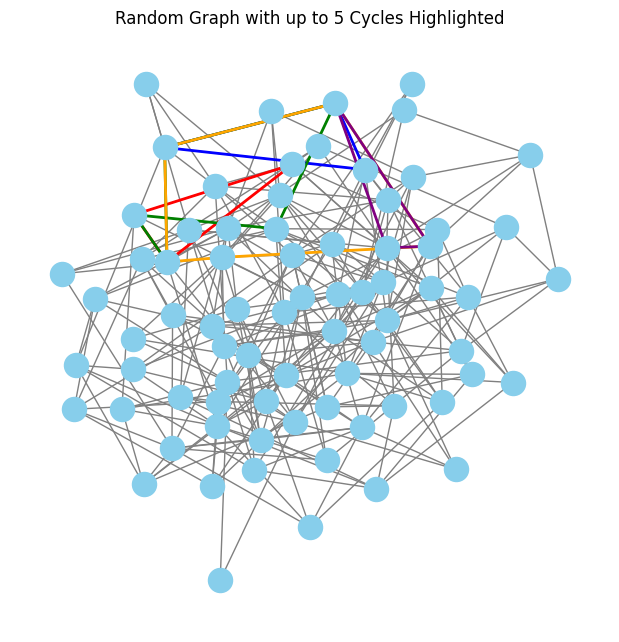

In [32]:
import networkx as nx
import matplotlib.pyplot as plt

# sample from Erdős–Rényi model of ALPHA_DF 
n, p = estimate_n_p(alpha_undirected)
print(f"Estimated n: {n}, p: {p}")
n = int(n / 50)
p = p * 50  # scale down for visualization
random_graph = nx.erdos_renyi_graph(n=n, p=p, seed=42)

# === Step 2: Detect 1D holes (simple cycles) ===
cycles = list(nx.cycle_basis(random_graph))
highlight_cycles = cycles[:5] if len(cycles) >= 5 else cycles

# Define colors for each cycle
cycle_colors = ['red', 'blue', 'green', 'orange', 'purple']

# === Step 3: Draw the graph without labels ===
pos = nx.spring_layout(random_graph, seed=42)

plt.figure(figsize=(6, 6))
nx.draw(random_graph, pos, with_labels=False, node_color='skyblue', edge_color='gray')

# Highlight each cycle in a different color
for idx, cycle in enumerate(highlight_cycles):
    color = cycle_colors[idx % len(cycle_colors)]
    cycle_edges = [(cycle[i], cycle[(i + 1) % len(cycle)]) for i in range(len(cycle))]
    nx.draw_networkx_edges(random_graph, pos, edgelist=cycle_edges, edge_color=color, width=2)

plt.title("Random Graph with up to 5 Cycles Highlighted")
plt.axis('off')
plt.show()


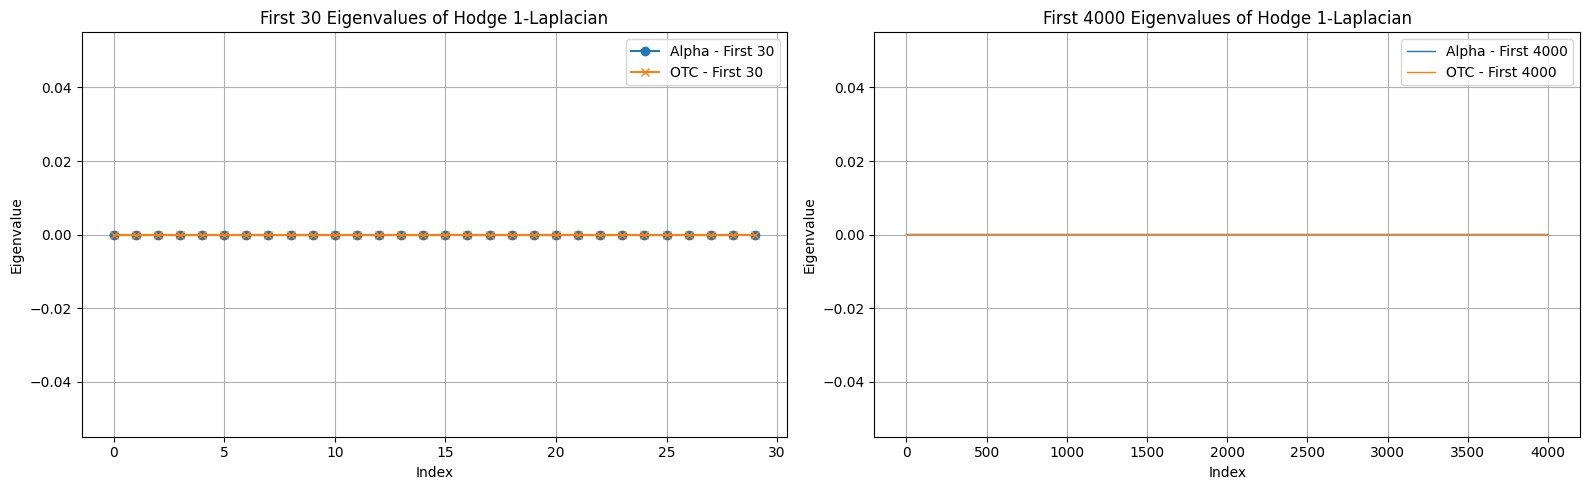

In [16]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

# Plot 1: First 30 eigenvalues
axes[0].plot(cleaned_eigenvalues_alpha[:30], label='Alpha - First 30', marker='o')
axes[0].plot(cleaned_eigenvalues_otc[:30], label='OTC - First 30', marker='x')
axes[0].set_title('First 30 Eigenvalues of Hodge 1-Laplacian')
axes[0].set_xlabel('Index')
axes[0].set_ylabel('Eigenvalue')
axes[0].legend()
axes[0].grid(True)

# Plot 2: First 300 eigenvalues
axes[1].plot(cleaned_eigenvalues_alpha[:4000], label='Alpha - First 4000', linewidth=1)
axes[1].plot(cleaned_eigenvalues_otc[:4000], label='OTC - First 4000', linewidth=1)
axes[1].set_title('First 4000 Eigenvalues of Hodge 1-Laplacian')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Eigenvalue')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# This is the actual communities of Alpha_G bitcoin network example of a hole in L1

In [17]:
# THIS BLOCK TAKES A LONG TIME TO RUN
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh

# --- Step 1: Rebuild the edge list and edge index (must match compute_hodge_1_laplacian)

edges_alpha = [tuple(sorted(e)) for e in alpha_G.edges()]
edge_index_alpha = {e: i for i, e in enumerate(edges_alpha)}
reverse_edge_index_alpha = {i: e for e, i in edge_index_alpha.items()}
print("Number of edges in Alpha Graph:", len(edges_alpha))

# --- Step 2: Compute eigenvectors of L1 and get harmonic ones (eigenvalue ≈ 0)
L1_alpha_random = compute_hodge_1_laplacian(alpha_random)
L1_alpha_random = L1_alpha_random.astype(np.float64)
print("Shape of Hodge 1 Laplacian for Alpha Random Graph:", L1_alpha_random.shape)

eigvals_alpha, eigvecs_alpha = eigsh(L1_alpha_random, k=100, which='SM')
import pickle

# Save eigenvalues and eigenvectors to disk
with open("eigvals_alpha.pkl", "wb") as f:
    pickle.dump((eigvals_alpha, eigvecs_alpha), f)

Number of edges in Alpha Graph: 24186
Shape of Hodge 1 Laplacian for Alpha Random Graph: (14131, 14131)


KeyboardInterrupt: 

In [ ]:
zero_indices = np.where(np.abs(eigvals_alpha) < 1e-10)[0]
print("Eigenvalues close to zero (harmonic cycles):", eigvals_alpha[zero_indices])

print(f"Number of harmonic cycles (holes): {len(zero_indices)}")

# Pick the first harmonic eigenvector
harmonic_vec = eigvecs_alpha[:, zero_indices[0]]

# Use same sorted edge list as in compute_hodge_1_laplacian
edges = [tuple(sorted(e)) for e in alpha_G.edges()]
reverse_edge_index_alpha = {i: e for i, e in enumerate(edges)}

# Threshold: select edges participating in this harmonic cycle
edge_ids = np.where(np.abs(harmonic_vec) > 1e-3)[0]
hole_edges = [reverse_edge_index_alpha[int(i)] for i in edge_ids]

print("Edges in the extracted harmonic hole:", hole_edges)



NameError: name 'eigvals_alpha' is not defined

In [ ]:
import random

# Sample up to 50 edges from the harmonic cycle
sampled_hole_edges = random.sample(hole_edges, min(250, len(hole_edges)))

# --- Step 3: Visualize the sampled hole as a subgraph
sampled_subgraph = nx.Graph()
sampled_subgraph.add_edges_from(sampled_hole_edges)

plt.figure(figsize=(6, 6))
pos = nx.spring_layout(sampled_subgraph, seed=42)
nx.draw(
    sampled_subgraph,
    pos,
    with_labels=False,
    edge_color='red',
    node_color='skyblue',
    node_size=80,
    width=1.5
)

plt.title("Sampled Harmonic 1-Cycle (Up to 250 Edges)")
plt.axis('off')
plt.show()


NameError: name 'hole_edges' is not defined

# Random walk on one of the edge nodes of the holes

In [ ]:
# Step 1: Build directed weighted graph from alpha_df
G_weighted = nx.DiGraph()
for src, tgt, w in zip(alpha_df['source'], alpha_df['target'], alpha_df['weight']): # weight is the transaction score
    G_weighted.add_edge(int(src), int(tgt), weight=w)

# Step 2: Convert sampled subgraph nodes into a directed weighted subgraph
nodes_in_sample = sampled_subgraph.nodes()
trust_subgraph = G_weighted.subgraph(nodes_in_sample).copy()

# Step 3: Random walk based on highest transaction score
def greedy_trust_walk(G, start_node, max_steps=100):
    path = [start_node]
    current = start_node

    for _ in range(max_steps):
        out_edges = list(G.out_edges(current, data='weight'))
        if not out_edges:
            break  # Stuck

        # Choose edge with max weight (most trustworthy)
        next_node = max(out_edges, key=lambda x: x[2])[1]
        if next_node in path:
            break  # Optional: avoid cycles
        path.append(next_node)
        current = next_node

    return path

# Step 4: Pick a random starting node and run
start_node = random.choice(list(trust_subgraph.nodes()))
walk_path = greedy_trust_walk(trust_subgraph, start_node)

print("Visited nodes in trust-based random walk:")
print(walk_path)


NameError: name 'nx' is not defined

In [ ]:
# Run the walk
start_node = random.choice(list(trust_subgraph.nodes()))
walk_path = greedy_trust_walk(trust_subgraph, start_node)

# --- Visualization
plt.figure(figsize=(6, 6))
pos = nx.spring_layout(sampled_subgraph, seed=42)

# Draw all nodes/edges in background
nx.draw_networkx_edges(sampled_subgraph, pos, edge_color='lightgray', width=0.8)
nx.draw_networkx_nodes(
    sampled_subgraph,
    pos,
    node_color='skyblue',
    node_size=60,
    alpha=0.4
)

# Highlight visited nodes
visited_set = set(walk_path)
nx.draw_networkx_nodes(
    sampled_subgraph,
    pos,
    nodelist=list(visited_set),
    node_color='red',
    node_size=120
)

# Optional: Draw walk path edges (in red)
walk_edges = list(zip(walk_path[:-1], walk_path[1:]))
nx.draw_networkx_edges(
    sampled_subgraph,
    pos,
    edgelist=walk_edges,
    edge_color='red',
    width=2
)

plt.title("Greedy Trust-Based Walk over Harmonic 1-Cycle Sample")
plt.axis('off')
plt.show()